In [241]:
import warnings; warnings.simplefilter('ignore')
import os
import sys
import time
import math
import shutil
import pickle
import random
import anndata
import operator
import matplotlib
import pylab as pl
import numpy as np
import pandas as pd
from umap import UMAP
import seaborn as sns
from scipy import sparse
from matplotlib import cm
from fish_helpers import *
from IPython import display
import tqdm#.notebook as tqdm
from scipy.stats import mode
from functools import partial
from segmentation_3D import *
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib._color_data as mcd
import scipy.cluster.hierarchy as shc
from scipy.interpolate import interp1d
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics.pairwise import euclidean_distances
base = '/bigstore/binfo/mouse/Hippocampus/'

In [242]:
cell_type_averages = pd.read_csv(os.path.join(base,'Allen/normalized_cell_type_average_counts.csv.gz'),index_col=0)

In [3]:
# """
# Loading Data from backup
# """
# raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/filtered_raw_counts.npz'))
# cells =  np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_cells.csv'),index_col=0)['0'])
# genes = np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_genes.csv'),index_col=0)['0'])
# metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0).loc[cells]
# good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
# raw_counts = raw_counts_sparse.A
# normalized_raw_counts = np.divide(raw_counts,np.sum(raw_counts,axis=0))*10**6
# del raw_counts
# normalized_raw_counts = pd.DataFrame(normalized_raw_counts,index=genes,columns=cells)
# m = np.max(cell_type_averages,axis=1)
# expression_filtered_genes = list(cell_type_averages[(m>10)&(m<1000)].index)
# expression_filtered_counts = normalized_raw_counts.loc[expression_filtered_genes]
# del normalized_raw_counts

In [243]:
"""
Load seperability filtered counts
"""
filtered_counts_sparse = sparse.load_npz(os.path.join(base,'Allen/seperability_filtered_counts_no_weights.npz'))
filtered_counts = filtered_counts_sparse.A
cells = list(pd.read_csv(os.path.join(base,'Allen/seperability_filtered_cells_no_weights.csv'),index_col=0)['0'])
filtered_genes = list(pd.read_csv(os.path.join(base,'Allen/seperability_filtered_genes_no_weights.csv'),index_col=0)['0'])
filtered_counts = pd.DataFrame(filtered_counts,index=filtered_genes,columns=cells)

In [244]:
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0).loc[cells]
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
sample_cluster_probabilities = pd.read_csv(os.path.join(base,'sample_cluster_probabilities.csv'),index_col=0)
prob = sample_cluster_probabilities.loc[cells]

In [95]:
corr = np.corrcoef(cell_type_averages.loc[filtered_genes])
corr_df = pd.DataFrame(corr,index=filtered_genes,columns=filtered_genes)
print(corr.shape)

(5000, 5000)


In [125]:
corr_df = pd.DataFrame(corr,index=filtered_genes,columns=filtered_genes)

In [135]:
gene = random.sample(filtered_genes,1)[0]
corr_df.sort_values(gene,ascending=False).index[1]

'Anapc13'

In [137]:
corr_df[gene].loc['Anapc13']

0.7195399017312081

In [183]:
nbits = 30
gene_bits = {}
used_genes = []
vector_bits = {}
# initialize
abs_corr_df = np.abs(corr_df)
for i in ipb(range(nbits)):
    if i==0:
        gene = random.sample(filtered_genes,1)[0]
    else:
        l = 0
        new_gene = gene
        while new_gene in used_genes:
            new_gene = abs_corr_df.sort_values(gene,ascending=True).index[l]
            l+=1
        gene = new_gene
    used_genes.append(gene)
    gene_bits[i] = [gene]
    vector_bits[i] = np.array(cell_type_averages.loc[gene])
unused_genes = filtered_genes
for i in range(10):
    unused_genes = [i for i in unused_genes if not i in used_genes]
    for gene in ipb(unused_genes):
        gene_vector = np.array(cell_type_averages.loc[gene])
        c = np.empty(nbits)
        for i,vector in vector_bits.items():
            c[i] = spearmanr(gene_vector,vector)[0]
        m = c.max() # No replacement
        if m>0.5:
            used_genes.append(gene)
            j = np.where(c==m)[0][0]
            gene_bits[j].append(gene)
            vector_bits[j] = np.array(cell_type_averages.loc[gene_bits[j]].sum())
        

 [████████████████████████████████████████████████████████████] 30/30 [00:05<00:00, 0.18s/it]

 [███████████████████████████████████████#####################] 3257/4970 [01:46<00:00, 0.03s/it]

KeyboardInterrupt: 

In [184]:
for i in gene_bits.keys():
    print(len(gene_bits[i]))

2
158
77
11
65
1
66
2
3
1
130
75
14
55
24
2
90
6
241
108
368
7
49
27
1
63
3
250
10
152


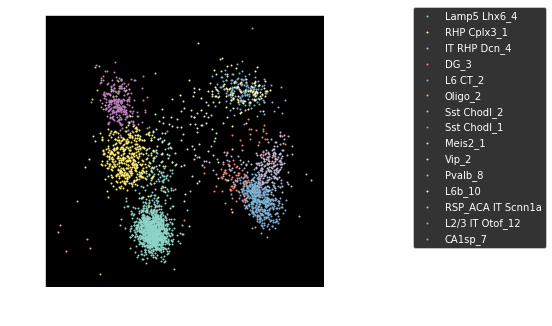

In [240]:
gl = np.array([len(gene_bits[i]) for i in gene_bits.keys()])
gl = list(np.array(list(gene_bits.keys()))[gl>10])
a = random.sample(gl,1)[0]
b = random.sample(gl,1)[0]
plt.figure(figsize=[5,5])
for cluster in random.sample(good_types,15):
    A = cell_type_dict[cluster].loc[gene_bits[a]].sum()
    B = cell_type_dict[cluster].loc[gene_bits[b]].sum()
    plt.scatter(np.log10(A),np.log10(B),s=1,label=cluster)
plt.xlabel(str(a)+'_'+str(len(gene_bits[a])))
plt.ylabel(str(b)+'_'+str(len(gene_bits[b])))
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

In [256]:
cell_type_dict = {}
for cluster in ipb(good_types):
    cell_type_dict[cluster] = filtered_counts[metadata[metadata['cell_type_alias_label']==cluster].index]

 [████████████████████████████████████████████████████████████] 290/290 [00:12<00:00, 0.04s/it]

In [271]:
corr = np.corrcoef(cell_type_averages.loc[filtered_genes])
corr_df = pd.DataFrame(corr,index=filtered_genes,columns=filtered_genes)
print(corr.shape)
a_gene = random.choice(filtered_genes)
a = list(corr_df.sort_values(a_gene,ascending=False)[a_gene].index[0:50])
b_gene = random.choice(filtered_genes)
b = list(corr_df.sort_values(b_gene,ascending=False)[b_gene].index[0:50])

(5000, 5000)


In [276]:
gene = random.choice(filtered_genes)
print(gene)
list(corr_df.sort_values(gene,ascending=False)[gene].index[0:50])

Mtmr12


['Mtmr12',
 'Camk2a',
 'Ppp3ca',
 'Arhgef9',
 'Bai2',
 'Mast3',
 'Cnksr2',
 'Slc8a2',
 'Nedd4l',
 'Btbd9',
 'Cdc40',
 'Dgkz',
 'Dagla',
 'Mark2',
 '2010300C02Rik',
 'Pip5k1a',
 'Camkk1',
 'Celf1',
 'Baiap2',
 'Kcnj6',
 'Synpo',
 'Pcdhgc5',
 'Mink1',
 'Plekhg5',
 'Arf3',
 'Bai1',
 'Spata2l',
 'Camk2b',
 'Ubtf',
 'Pip4k2c',
 'Fam212b',
 'Elmo2',
 'Ptk2b',
 'Phyhip',
 'Epha4',
 'Nckap1',
 'Rnf112',
 'Fbxo34',
 'Neurod1',
 'Arhgef25',
 'Egr3',
 'Nell2',
 '3110082I17Rik',
 'Dnajb5',
 'Zbtb18',
 'Crtc1',
 'Rab40b',
 'Neurod2',
 'Mef2d',
 'Rapgefl1']

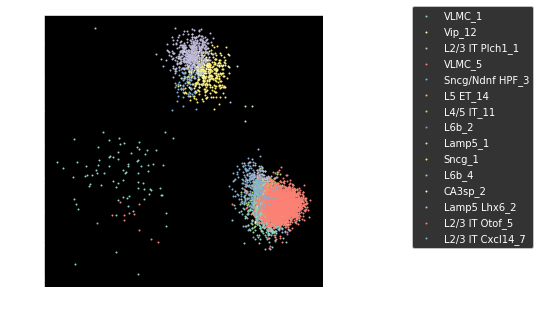

In [295]:
gl = filtered_genes
a_gene = random.choice(filtered_genes)
a = list(corr_df.sort_values(a_gene,ascending=False)[a_gene].index[0:50])
b_gene = random.choice(filtered_genes)
b = list(corr_df.sort_values(b_gene,ascending=False)[b_gene].index[0:50])
plt.figure(figsize=[5,5])
for cluster in random.sample(good_types,15):
    df = cell_type_dict[cluster]
    A = df.loc[a].sum()
    B = df.loc[b].sum()
    plt.scatter(np.log10(A),np.log10(B),s=1,label=cluster)
plt.xlabel(a_gene)
plt.ylabel(b_gene)
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

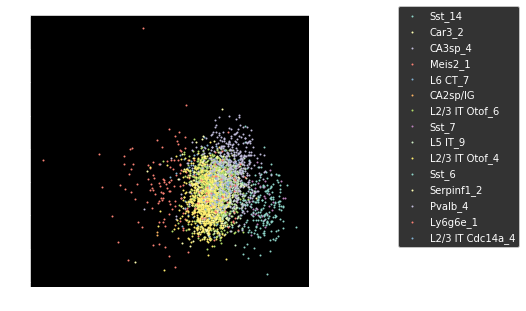

In [270]:
gl = filtered_genes
a = random.sample(gl,50)
b = random.sample(gl,50)
plt.figure(figsize=[5,5])
for cluster in random.sample(good_types,15):
    df = cell_type_dict[cluster]
    A = df.loc[a].sum()
    B = df.loc[b].sum()
    plt.scatter(np.log10(A),np.log10(B),s=1,label=cluster)
# plt.xlabel(str(a)+'_'+str(len(gene_bits[a])))
# plt.ylabel(str(b)+'_'+str(len(gene_bits[b])))
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

In [172]:
nbits = 30
gene_bits = {}
used_genes = list(random.sample(filtered_genes,nbits))
vector_bits = {}
for i,gene in enumerate(used_genes): # maybe start orthoganol
    gene_bits[i] = [gene]
    vector_bits[i] = np.array(cell_type_averages.loc[gene])
unused_genes = filtered_genes
for i in range(10):
    if i==0:
        nunused_genes = 0
    else:
        nunused_genes = len(unused_genes)
    unused_genes = [i for i in unused_genes if not i in used_genes]
    if np.abs(len(unused_genes)-nunused_genes)>100:
        for gene in ipb(unused_genes):
            gene_vector = np.array(cell_type_averages.loc[gene])
            corr = np.empty(nbits)
            for i,vector in vector_bits.items():
                corr[i] = spearmanr(gene_vector,vector)[0]
            m = corr.max() # No replacement
            if m>0.7:
                used_genes.append(gene)
                j = np.where(corr==m)[0][0]
                gene_bits[j].append(gene)
                vector_bits[j] = np.array(cell_type_averages.loc[gene_bits[j]].sum())

 [█###########################################################] 150/4970 [00:05<00:00, 0.03s/it]

KeyboardInterrupt: 

In [171]:
len(unused_genes)-nunused_genes<100

True

In [ ]:
a = random.sample(list(gene_bits.keys()),1)[0]
b = random.sample(list(gene_bits.keys()),1)[0]
plt.figure(figsize=[5,5])
for cluster in random.sample(good_types,10):
    A = cell_type_dict[cluster].loc[gene_bits[a]].sum()
    B = cell_type_dict[cluster].loc[gene_bits[b]].sum()
    plt.scatter(np.log10(A),np.log10(B),s=1,label=cluster)
plt.xlabel(str(a)+'_'+str(len(gene_bits[a])))
plt.ylabel(str(b)+'_'+str(len(gene_bits[b])))
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

In [ ]:
"""
hierarcheal cluustering by correlation for all cells
"""


In [83]:
len(used_genes)

3345

In [89]:
for i in gene_bits.keys():
    print(len(gene_bits[i]))

454
112
359
68
169
112
68
1
158
1
7
2
62
88
359
235
40
4
193
2
72
295
255
1
1
64
143
1
136
64


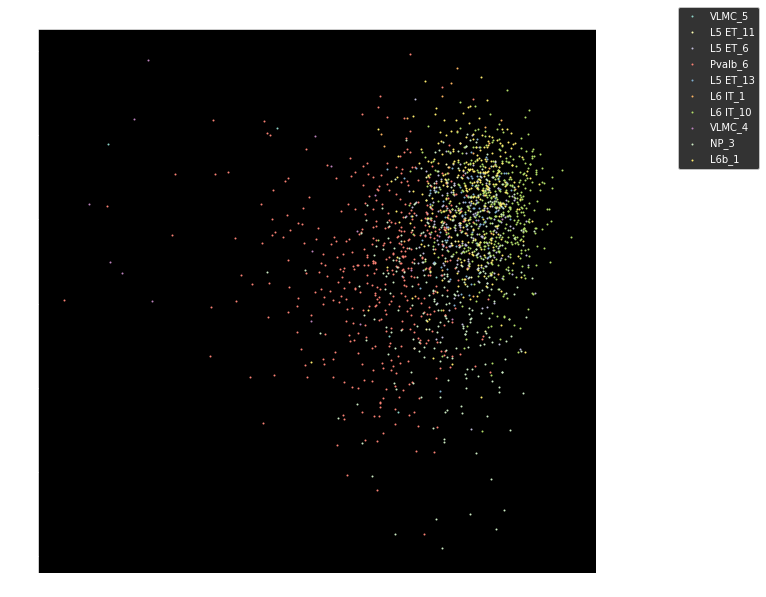

In [164]:
a = gene_bits[0]
b = gene_bits[5]
plt.figure(figsize=[10,10])
for cluster in random.sample(good_types,10):
    A = cell_type_dict[cluster].loc[a].sum()
    B = cell_type_dict[cluster].loc[b].sum()
    plt.scatter(np.log10(A),np.log10(B),s=1,label=cluster)
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

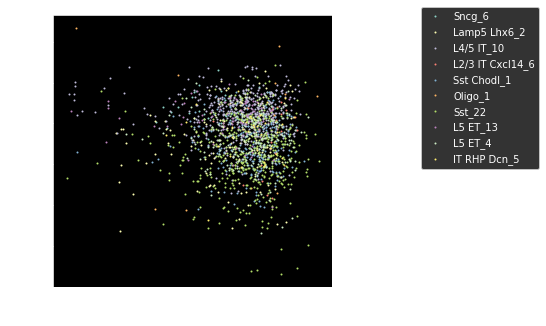

In [168]:
a = random.sample(list(gene_bits.keys()),1)[0]
b = random.sample(list(gene_bits.keys()),1)[0]
plt.figure(figsize=[5,5])
for cluster in random.sample(good_types,10):
    A = cell_type_dict[cluster].loc[gene_bits[a]].sum()
    B = cell_type_dict[cluster].loc[gene_bits[b]].sum()
    plt.scatter(np.log10(A),np.log10(B),s=1,label=cluster)
plt.xlabel(str(a)+'_'+str(len(gene_bits[a])))
plt.ylabel(str(b)+'_'+str(len(gene_bits[b])))
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

In [71]:
random.sample(list(gene_bits.keys()),1)

[8]

In [9]:
import scipy.cluster.hierarchy as shc
linkage = shc.linkage(corr)

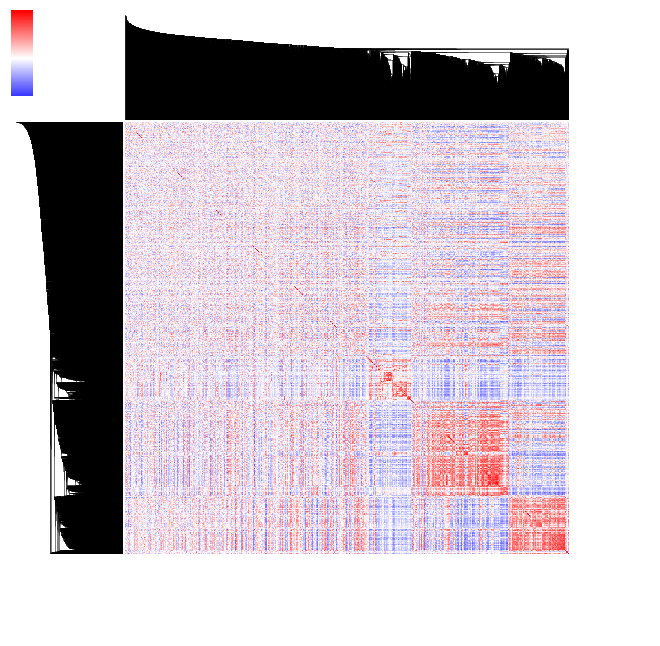

In [10]:
sns.clustermap(pd.DataFrame(corr,index=filtered_genes,columns=filtered_genes),cmap='bwr',center=0,row_linkage=linkage,col_linkage=linkage)
plt.show()

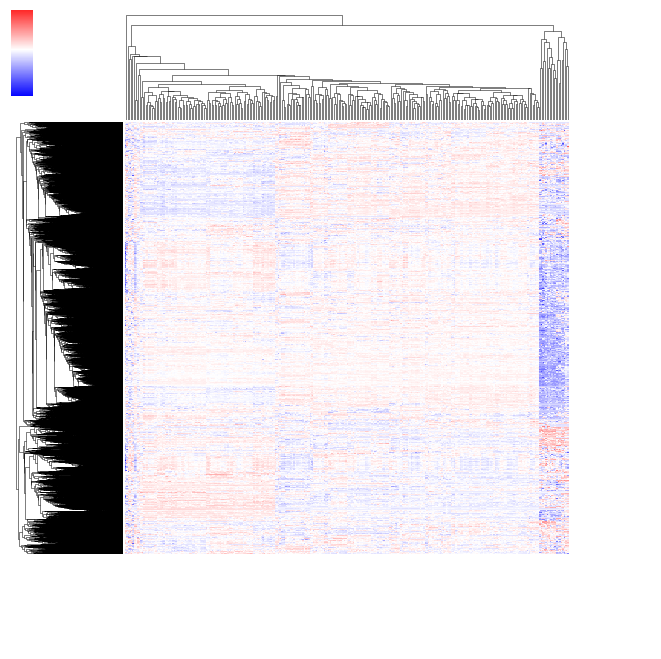

In [13]:
sns.clustermap(np.log10(cell_type_averages.loc[filtered_genes]+1),cmap='bwr',center=0,z_score=0)
plt.show()

 [████████████████████████████████████████████████████████████] 290/290 [00:17<00:00, 0.06s/it]

 [████████████████████████████████████████████████████████████] 11/11 [02:59<01:18, 16.31s/it]

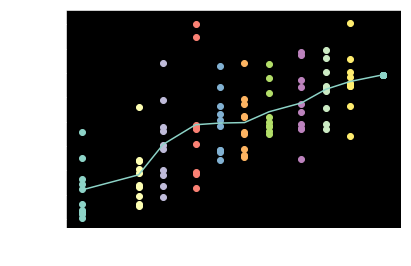

In [6]:
nsums = 10
ngenes_dict = {}
cell_type_dict = {}
for cluster in ipb(good_types):
    cell_type_dict[cluster] = filtered_counts[metadata[metadata['cell_type_alias_label']==cluster].index]
seperability_df = pd.DataFrame()
ngene_range = [1,5,10,25,50,100,200,500,1000,2000,5000]
for ngenes in ipb(ngene_range):
    ngenes_dict[ngenes] = {}
    ngenes_dict[ngenes]['avg'] = pd.DataFrame(index=good_types)
    ngenes_dict[ngenes]['std'] = pd.DataFrame(index=good_types)
    sep = []
    for i in range(nsums):
        rgenes = random.sample(filtered_genes,ngenes)
        avg = np.empty(len(good_types))
        std = np.empty(len(good_types))
        for x,cluster in enumerate(good_types):
            temp = cell_type_dict[cluster].loc[rgenes].sum()
            avg[x] = np.average(temp)
            std[x] = np.std(temp)
        ngenes_dict[ngenes]['avg'][i] = avg
        ngenes_dict[ngenes]['std'][i] = std
        seperability = np.nansum((np.abs(np.subtract(avg[:,None],avg[None,:]))/np.add(std[:,None],std[None,:])))#*weight_matrix)
        sep.append(seperability)
    seperability_df[ngenes] = sep
for ngenes in ngene_range:
    plt.scatter(np.log10([int(ngenes) for i in seperability_df.index]),seperability_df[ngenes],label=ngenes)
plt.plot(np.log10(seperability_df.columns),np.average(seperability_df,axis=0))
plt.xlabel('log10 number of genes to sum')
plt.ylabel('seperability')
plt.show()

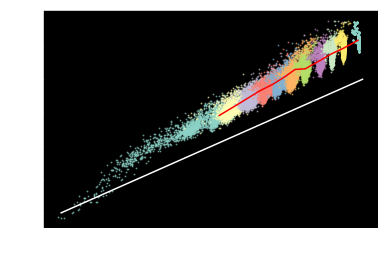

In [7]:
x = []
y = []
for ngenes in ngenes_dict.keys():
    std_df = ngenes_dict[ngenes]['std']
    avg_df = ngenes_dict[ngenes]['avg']
    X = []
    Y = []
    for i in std_df.columns:
        X.extend(avg_df[i])
        Y.extend(std_df[i])
    x.append(np.mean(X))
    y.append(np.mean(Y))
    plt.scatter(np.log10(np.sqrt(X)),np.log10(Y),s=1,label=ngenes,alpha=0.5)
plt.plot(np.log10(np.sqrt(x)),np.log10(y),c='r')
plt.plot([-1,3],[-1,3],c='w')
plt.xlabel('log10 sqrt expression (sum)')
plt.ylabel('log std')
plt.show()

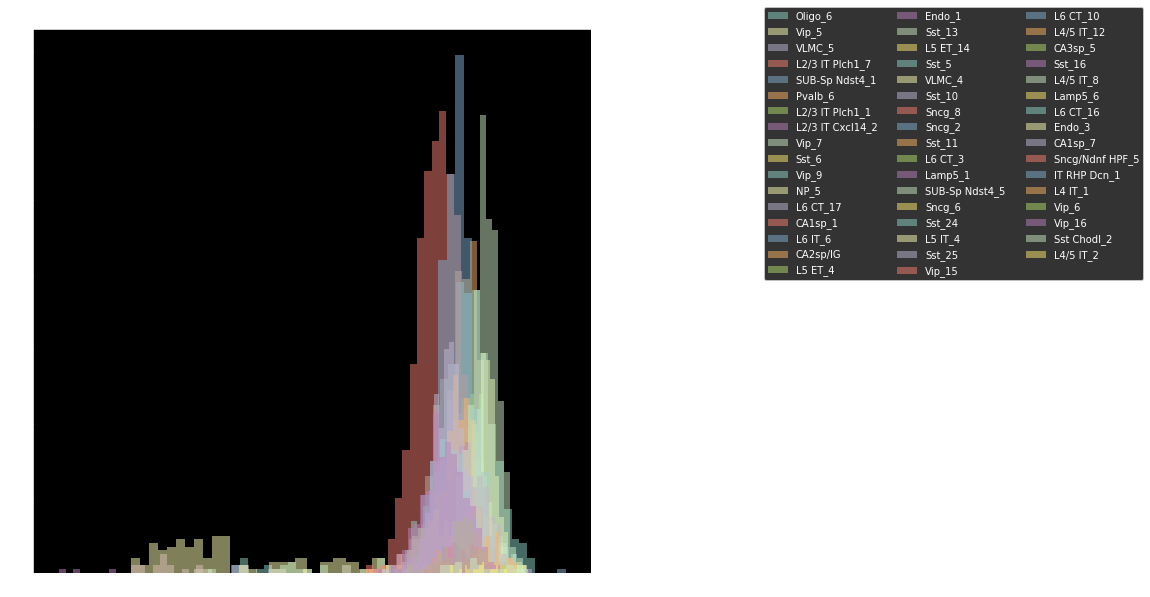

In [10]:
plt.figure(figsize = [10,10])
for cluster in random.sample(good_types,50):
    plt.hist(filtered_counts[metadata[metadata['cell_type_alias_label']==cluster].index].sum(),label=cluster,alpha=0.5,bins=20)
plt.legend(bbox_to_anchor=(1.3, 1.05),ncol=3)
plt.show()

 [████████████████████████████████████████████████████████████] 290/290 [01:09<00:00, 0.24s/it]

 [████████████████████████████████████████████████████████████] 12/12 [07:04<03:32, 35.35s/it]

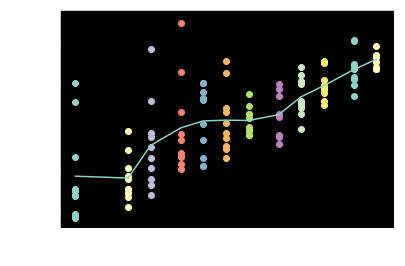

In [122]:
nsums = 10
ngenes_dict = {}
cell_type_dict = {}
for cluster in ipb(good_types):
    cell_type_dict[cluster] = expression_filtered_counts[metadata[metadata['cell_type_alias_label']==cluster].index]
seperability_df = pd.DataFrame()
ngene_range = [1,5,10,25,50,100,200,500,1000,2000,5000,10000]
for ngenes in ipb(ngene_range):
    ngenes_dict[ngenes] = {}
    ngenes_dict[ngenes]['avg'] = pd.DataFrame(index=good_types)
    ngenes_dict[ngenes]['std'] = pd.DataFrame(index=good_types)
    sep = []
    for i in range(nsums):
        rgenes = random.sample(expression_filtered_genes,ngenes)
        avg = np.empty(len(good_types))
        std = np.empty(len(good_types))
        for x,cluster in enumerate(good_types):
            temp = cell_type_dict[cluster].loc[rgenes].sum()
            avg[x] = np.average(temp)
            std[x] = np.std(temp)
        ngenes_dict[ngenes]['avg'][i] = avg
        ngenes_dict[ngenes]['std'][i] = std
        seperability = np.nansum((np.abs(np.subtract(avg[:,None],avg[None,:]))/np.add(std[:,None],std[None,:])))#*weight_matrix)
        sep.append(seperability)
    seperability_df[ngenes] = sep
for ngenes in ngene_range:
    plt.scatter(np.log10([int(ngenes) for i in seperability_df.index]),seperability_df[ngenes],label=ngenes)
plt.plot(np.log10(seperability_df.columns),np.average(seperability_df,axis=0))
plt.xlabel('log10 number of genes to sum')
plt.ylabel('seperability')
plt.show()

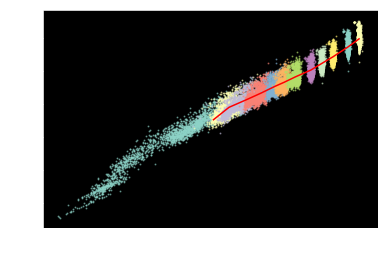

In [128]:
x = []
y = []
for ngenes in ngenes_dict.keys():
    std_df = ngenes_dict[ngenes]['std']
    avg_df = ngenes_dict[ngenes]['avg']
    X = []
    Y = []
    for i in std_df.columns:
        X.extend(avg_df[i])
        Y.extend(std_df[i])
    x.append(np.mean(X))
    y.append(np.mean(Y))
    plt.scatter(np.log10(X),np.log10(Y),s=1,label=ngenes,alpha=0.5)
plt.plot(np.log10(x),np.log10(y),c='r')
plt.xlabel('log10 expression (sum)')
plt.ylabel('std')
plt.show()

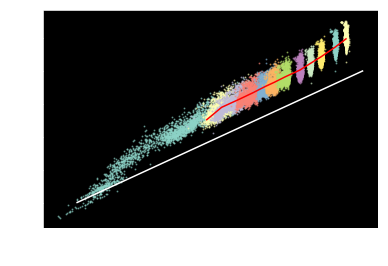

In [131]:
x = []
y = []
for ngenes in ngenes_dict.keys():
    std_df = ngenes_dict[ngenes]['std']
    avg_df = ngenes_dict[ngenes]['avg']
    X = []
    Y = []
    for i in std_df.columns:
        X.extend(avg_df[i])
        Y.extend(std_df[i])
    x.append(np.mean(X))
    y.append(np.mean(Y))
    plt.scatter(np.log10(np.sqrt(X)),np.log10(Y),s=1,label=ngenes,alpha=0.5)
plt.plot(np.log10(np.sqrt(x)),np.log10(y),c='r')
plt.plot([-1,3],[-1,3],c='w')
plt.xlabel('log10 sqrt expression (sum)')
plt.ylabel('log std')
plt.show()

In [17]:
cell_type_dict = {}
for cluster in ipb(good_types):
    cell_type_dict[cluster] = filtered_counts[metadata[metadata['cell_type_alias_label']==cluster].index]

 [████████████████████████████████████████████████████████████] 290/290 [00:17<00:00, 0.06s/it]

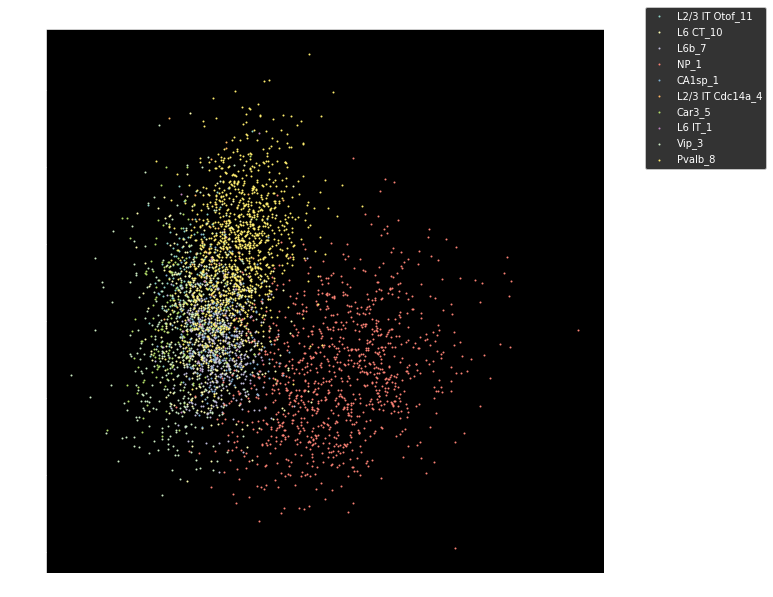

In [18]:
a = random.sample(filtered_genes,50)
b = random.sample(filtered_genes,50)
plt.figure(figsize=[10,10])
for cluster in random.sample(good_types,10):
    A = cell_type_dict[cluster].loc[a].sum()
    B = cell_type_dict[cluster].loc[b].sum()
    plt.scatter(A,B,s=1,label=cluster)
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

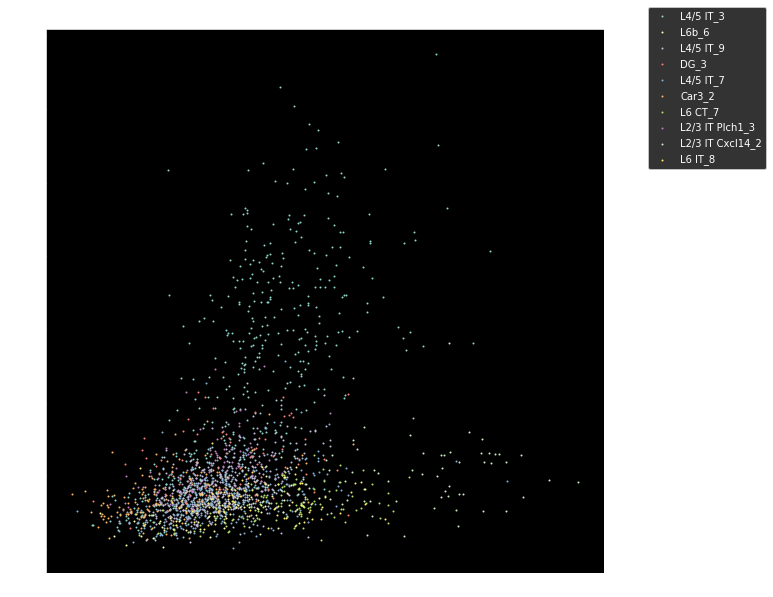

In [19]:
a = random.sample(filtered_genes,50)
b = random.sample(filtered_genes,50)
plt.figure(figsize=[10,10])
for cluster in random.sample(good_types,10):
    A = cell_type_dict[cluster].loc[a].sum()
    B = cell_type_dict[cluster].loc[b].sum()
    plt.scatter(A,B,s=1,label=cluster)
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.show()

In [56]:
"""
Decoding dendogram
Converting to linkage
"""
import json
with open('/bigstore/binfo/mouse/Hippocampus/dend.json') as json_file:
    data = json.load(json_file)
def inspect_node(node):
    if 'leaf_attributes' in node.keys():
        attributes = node['leaf_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        a = 'None'
        b = 'None'
        children = False
    else:
        attributes = node['node_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        children = node['children']
        a_node = node['children'][0]
        if 'leaf_attributes' in a_node.keys():
            a = a_node['leaf_attributes'][0]['node_id']
        else:
            a = a_node['node_attributes'][0]['node_id']
        b_node = node['children'][1]
        if 'leaf_attributes' in b_node.keys():
            b = b_node['leaf_attributes'][0]['node_id']
        else:
            b = b_node['node_attributes'][0]['node_id']
    return c,h,a,b,children

C = []
H = []
A = []
B = []
node_dict = {}

node = data
c,h,a,b,children = inspect_node(node)
C.append(c)
H.append(h)
A.append(a)
B.append(b)
while len(children)>0:
    new_children = []
    for node in children:
        c,h,a,b,node_children = inspect_node(node)
        C.append(c)
        H.append(h)
        A.append(a)
        B.append(b)
        if isinstance(node_children,list):
            new_children.extend(node_children)
    children = new_children
linkage = pd.DataFrame()
linkage['C'] = C
linkage['H'] = H
linkage['A'] = A
linkage['B'] = B
print(len(C))
"""
Convert linkage to dendrogram format
"""
sorted_linkage = linkage.sort_values('H',ascending=True)
sorted_linkage['n'] = range(len(sorted_linkage))
nA = []
for A in sorted_linkage['A']:
    if A!='None':
        nA.append(np.array(sorted_linkage[sorted_linkage['C']==A]['n'])[0])
    else:
        nA.append('None')
nB = []
for B in sorted_linkage['B']:
    if B!='None':
        nB.append(np.array(sorted_linkage[sorted_linkage['C']==B]['n'])[0])
    else:
        nB.append('None')
sorted_linkage['nA'] = nA
sorted_linkage['nB'] = nB
sorted_linkage['nC'] = list(sorted_linkage['n'])
sorted_linkage = sorted_linkage[sorted_linkage['H']>0]
sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1

579


In [59]:
"""
Convert to cell type by node matrix
"""
def find_next_node(i,df):
    temp = df[(df['A']==i)|(df['B']==i)]
    if len(temp)==1:
        return temp['C'].iloc[0]
    else:
        return False
def linkage2binary(linkage,cells):
    nnodes = len(linkage)
    ncells = len(cells)
    binary_node_matrix = np.zeros((ncells,nnodes))
    first_node = linkage['C'].iloc[0]
    for i,cell in tqdm.tqdm(enumerate(cells),total=ncells):
        node_loc = list(linkage[linkage['C']==cell].index)[0]
        binary_node_matrix[i,node_loc]=1
        new_node = find_next_node(cell,linkage)
        while isinstance(new_node,str):
            node_loc = list(linkage[linkage['C']==new_node].index)[0]
            binary_node_matrix[i,node_loc]=1
            new_node = find_next_node(new_node,linkage)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells,columns=list(linkage['C']))
    return binary_node_df
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
binary_node_df = linkage2binary(linkage,good_types).T

100%|██████████| 290/290 [00:14<00:00, 20.50it/s]


In [60]:
"""
Build cell type to cell type weight matrix
"""
n_cell_types = len(good_types)
weight_matrix = np.zeros((n_cell_types,n_cell_types))
for x,cell_type1 in tqdm.tqdm(enumerate(good_types),total=n_cell_types):
    for y,cell_type2 in enumerate(good_types):
        if x<y:
            ancester_nodes = list(binary_node_df[(binary_node_df[cell_type1]==1)&(binary_node_df[cell_type2]==1)].index)
            weight = np.min(linkage[linkage['C'].isin(ancester_nodes)]['H'])
            weight_matrix[x,y] = weight
            weight_matrix[y,x] = weight
weight_matrix_df = pd.DataFrame(weight_matrix,index=good_types,columns=good_types)

100%|██████████| 290/290 [01:56<00:00,  2.50it/s]


In [ ]:
node_matrix = np.zeros((len(cells),len(binary_node_df.index)))
for cell_type in tqdm.tqdm(good_types):
    cell_type_cells = list(metadata[metadata['cell_type_alias_label']==cell_type].index)
    cell_type_cells = list(set(cell_type_cells).intersection(cells))
    cell_type_node = np.array(binary_node_df[cell_type])
    node_matrix[np.where(np.isin(cells,cell_type_cells)),:] = cell_type_node
node_df = pd.DataFrame(node_matrix,index=cells,columns=binary_node_df.index)

In [ ]:
"""
Metric for dendrogram accuracy
sum of (weights+1 * accuracy)/ncells 
weights = node by weight df linkage['H']
ncells = node by ncells df from node_df
could be same df
"""
temp = linkage
temp.index = temp['C']
node_metrics = pd.DataFrame(index=node_df.columns)
node_metrics['weights'] = 1+pd.DataFrame(temp['H'])
node_metrics['ncells'] = pd.DataFrame(node_df.sum())
node_metrics

In [ ]:
"""
Filtered CSI matrix format
"""
matrix_df = pd.DataFrame(filtered_counts,index=filtered_genes,columns=cells)
# avg = np.median(filtered_counts,axis=1)
# std = np.std(filtered_counts,axis=1)
# zscore = pd.DataFrame(filtered_counts-avg[:,None]/std[:,None],index=filtered_genes,columns=cells)
info_df = metadata.loc[cells]
info_df['cell_type'] = info_df['cell_type_alias_label']
info_df

In [ ]:
base_path = '/bigstore/GeneralStorage/Zach/CSI/Allen_CSI/'
if not os.path.exists(base_path):
    os.mkdir(base_path)
class CompressedSensingClass(object):
    def __init__(self,matrix,
                 info_df=[],
                 node_df=[],
                 node_metrics=[],
                 avg=[],
                 std=[],
                 zscore=[],
                 which_genes=[],
                 subsample=1000,
                 noise = 0.1,
                 metric='cell_type',
                 nblanks=None,
                 npos=1000,
                 nbits=18,
                 ncpu=1,
                 pop_ncpu=1,
                 keepers=10,
                 mutation_rate=0.1,
                 offspring_number=0,
                 mutation_number=0,
                 k=100,
                 sample=1000,
                 survivors=[],
                 iterations=100,
                 base_path='',
                 color='r',
                 fresh=True,
                 verbose=True):
        if base_path == '':
            base_path = os.path.join(os.getcwd(),'Results')
        self.base_path = base_path
        if not os.path.exists(self.base_path):
            os.mkdir(self.base_path)
            
        matrix = matrix.astype('int16')
        self.node_df = node_df
        self.node_metrics = node_metrics
        self.noise = noise
        self.metric = metric
        self.info_df = info_df
        self.cell_types = self.info_df.cell_type.unique()
        self.fresh = fresh
        self.verbose = verbose
        self.zscore = zscore
        self.std = std
        self.avg = avg
        self.cells = list(matrix.columns)
        self.ncells = len(self.cells)
        self.full_matrix = matrix
        if nblanks==None:
            nblanks = npos
        if nblanks>0:
            blanks = pd.DataFrame(np.zeros((nblanks,self.ncells)),index=['blank'+str(i)for i in range(nblanks)],columns=self.cells)
            if len(which_genes)==0:
                self.matrix = pd.concat([matrix,blanks])
            else:
                self.matrix = pd.concat([matrix.loc[which_genes],blanks])
        else:
            if len(which_genes)==0:
                self.matrix = matrix
            else:
                self.matrix = matrix.loc[which_genes]
        self.nblanks = nblanks
        self.genes = list(self.matrix.index)
        self.ngenes = len(self.genes)
        self.npos = npos
        self.nbits = nbits
        self.ncpu = ncpu
        self.pop_ncpu = pop_ncpu
        self.keepers = keepers
        self.ideal = np.zeros(self.ngenes)
        self.ideal[0:npos] = 1
        self.ideal = list(self.ideal)
        self.mutation_rate = mutation_rate
        self.offspring_number = offspring_number
        self.mutation_number = mutation_number
        self.k = k # could infer
        self.sample = sample
        self.survivors = survivors
        self.iterations = iterations
        self.color = color
        if self.metric =='imputation':
            if len(zscore)==0:
                raise NameError('for imputation you need a zscore')
        elif self.metric == 'cell_type':
            if len(info_df)==0:
                raise NameError('for cell_type you need a info_df')
        elif self.metric == 'dendrogram':
            if len(info_df)==0:
                raise NameError('for dendrogram you need a info_df')
            if len(node_df)==0:
                raise NameError('for dendrogram you need a node_df')
            if len(node_metrics)==0:
                raise NameError('for dendrogram you need a node_metrics')
        else:
            print(self.metric)
            raise NameError(self.metric,'Is not a possible type')

    def generate_random(self):
        species = np.zeros((self.ngenes,self.nbits))
        mutable = int(self.npos)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        species[x,y] = 1
        return species

    def generate_starting_survivors(self):
        survivors = []
        for k in range(self.keepers):
            survivors.append(self.generate_random())
        self.survivors = survivors

    def generate_mutations(self,species):
        mutated = species.copy()
        possible_mutations = self.generate_random()
        mutable = int(random.random()*self.mutation_rate*self.ngenes*self.nbits)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        mutated[x,y] = possible_mutations[x,y]
        return mutated

    def generate_offspring(self,species,mate):
        offspring = species.copy()
        mutable = int(0.5*self.ngenes*self.nbits)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        offspring[x,y] = mate[x,y]
        return offspring

    def generate_progenerators(self):
        progenerators = self.survivors.copy()
        for species in self.survivors:
            for i in range(self.offspring_number):
                mate = self.survivors[random.randint(0,self.keepers-1)].copy()
                progenerators.append(self.generate_offspring(species,mate))
        self.progenerators = progenerators

    def pfunc_generate_mutations(self,species):
        ppopulation = []
        for i in range(self.mutation_number):
            ppopulation.append(self.generate_mutations(species))
        return ppopulation

    def generate_population(self):
        population = self.progenerators.copy()
        if self.mutation_number>0:
            if self.pop_ncpu==1:
                for species in self.progenerators:
                    for i in range(self.mutation_number):
                        population.append(self.generate_mutations(species))
            else:
                sys.stdout.flush()
                with Pool(self.pop_ncpu) as p:
                    for ppopulation in p.imap(self.pfunc_generate_mutations,self.progenerators,chunksize=1):
                        for species in ppopulation:
                            population.append(species)
                sys.stdout.flush()
        self.population = population

    def generate_compressed(self,species):
        compressed = pd.DataFrame(index=self.cells)
        temp_matrix = np.array(self.matrix)
        out = []
        for i in range(self.nbits):
            compressed[i] = np.sum(np.multiply(temp_matrix,species[:,i][...,None]),axis=0)
        return compressed
    
    def imputation_metric(self,n,rank):
        cells = np.array(self.cells)
        metrics = []
        for i,idx in enumerate(n):
            cell = cells[idx]
            knn = cells[rank[:,i]]
            knn = knn[knn!=cell]
            zsig = self.zscore[cell]
            znn = np.average(self.zscore[knn],axis=1)
            metric = spearmanr(zsig,znn)[0]
            metrics.append(metric)
        metric = np.average(metrics)
        return metric
    
    def cell_type_metric(self,n,rank):
        cells = np.array(self.cells)
        metrics = []
        for i,idx in enumerate(n):
            cell = cells[idx]
            knn = cells[rank[:,i]]
            knn = knn[knn!=cell]
            cell = self.info_df.loc[cell].cell_type
            temp_df = self.info_df.loc[knn]
            metric = len(temp_df[temp_df.cell_type==cell])/self.k
            metrics.append(metric)
        metric = np.average(metrics)
        return metric

    def calculate_accuracy_dendrogram(self,truth,imputed):
        accuracy_matrix = np.zeros(len(imputed.columns))
        for i,node in enumerate(imputed.columns):
            imputed_cells = list(imputed[imputed[node]==1].index)
            truth_cells = list(truth[truth[node]==1].index)
            true = len(set(imputed_cells).intersection(truth_cells))
            ltruth = len(truth_cells)
            if ltruth>0:
                accuracy_matrix[i] = true/ltruth
            else:
                accuracy_matrix[i] = 0
        return accuracy_matrix
    
    def calculate_node_accuracy(self,compressed):
        X = np.array(compressed.copy())
        cells = np.array(self.cells)
        n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
        test_cells = cells[n]
        noise = np.random.randn(len(n),self.nbits)
        sim = X[n,:]+(self.noise*X[n,:]*noise)
        dist = euclidean_distances(X, sim)
        rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
        test_cells = cells[n]
        imputed_node_df = pd.DataFrame(index=test_cells,columns=self.node_df.columns)
        nn_cells = cells[rank[1,:]]
        temp = self.node_df.loc[nn_cells]
        temp.index = test_cells
        imputed_node_df.loc[test_cells] = temp
        truth_node_df = self.node_df.loc[test_cells]
        accuracy_matrix = self.calculate_accuracy_dendrogram(truth_node_df,imputed_node_df)
        return accuracy_matrix
    
    def dendrogram_metric(self,n,rank):
        cells = np.array(self.cells)
        test_cells = cells[n]
        imputed_node_df = pd.DataFrame(index=test_cells,columns=self.node_df.columns)
        nn_cells = cells[rank[1,:]]
        temp = self.node_df.loc[nn_cells]
        temp.index = test_cells
        imputed_node_df.loc[test_cells] = temp
        truth_node_df = self.node_df.loc[test_cells]
        accuracy_matrix = self.calculate_accuracy_dendrogram(truth_node_df,imputed_node_df)
        accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=imputed_node_df.columns,columns=['accuracy'])
        accuracy_matrix_df = pd.concat([accuracy_matrix_df,self.node_metrics],axis=1)
#         metric = np.sum(accuracy_matrix_df['accuracy']*accuracy_matrix_df['weights']*accuracy_matrix_df['ncells'])
        metric = np.sum(accuracy_matrix_df['accuracy']/accuracy_matrix_df['ncells'])
        return metric
    
    def calculate_metric(self,compressed):
        X = np.array(compressed.copy())
        cells = np.array(self.cells)
        n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
        test_cells = cells[n]
        noise = np.random.randn(len(n),self.nbits)
        sim = X[n,:]+(self.noise*X[n,:]*noise)
        dist = euclidean_distances(X, sim)
        rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
        if self.metric =='imputation':
            return self.imputation_metric(n,rank)
        elif self.metric == 'cell_type':
            return self.cell_type_metric(n,rank)
        elif self.metric == 'dendrogram':
            return self.dendrogram_metric(n,rank)

    def pfunc(self,species):
        compressed = self.generate_compressed(species)
        metric = self.calculate_metric(compressed)
        return species,compressed,metric
    
    def selection(self):
        new_population = []
        compresseds = []
        metrics = []
        if self.ncpu==1:
            for species in tqdm.tqdm(self.population):
                species,compressed,metric = self.pfunc(species)
                new_population.append(species)
                compresseds.append(compressed)
                metrics.append(metric)
        else:
            sys.stdout.flush()
            with Pool(self.ncpu) as p:
                for species,compressed,metric in tqdm.tqdm(p.imap(self.pfunc,self.population,chunksize=1),total=len(self.population)):
                    new_population.append(species)
                    compresseds.append(compressed)
                    metrics.append(metric)
            sys.stdout.flush()
        df = pd.DataFrame(index=range(len(self.population)))
        df['population'] = new_population
        df['metrics'] = metrics
        df['compresseds'] = compresseds
        df = df.sort_values('metrics',ascending=False)
        survivors = df.iloc[:self.keepers]
        self.metrics = list(survivors['metrics'])
        self.compresseds = list(survivors['compresseds'])
        self.survivors = list(survivors['population'])
        self.elite_survivor = self.survivors[0]
    
    def populate(self):
        self.generate_progenerators()
        self.generate_population()
            
    def evolve(self):
        start_time = time.time()
        self.X = []
        self.Y = []
        self.max = []
        self.min = []
        if len(self.survivors) != self.keepers:
            self.generate_starting_survivors()
        display.clear_output(wait=True)
        for I in range(self.iterations):
            if self.verbose:
                print('Iteration '+str(I))
            self.populate()
            if self.verbose:
                print('Population Generated '+str(len(self.population)))
            self.selection()
            if self.verbose:
                print('Selection Complete')
            pickle.dump(self.elite_survivor,open(os.path.join(self.base_path,str('elite_survivor_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.survivors,open(os.path.join(self.base_path,str('survivors_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.metrics,open(os.path.join(self.base_path,str('metrics_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.compresseds,open(os.path.join(self.base_path,str('compresseds_'+str(I)+'.pkl')),'wb'))
            avg = np.average(self.metrics)
            std = np.std(self.metrics) 
            self.X.append((time.time()-start_time)/(60*60))
            self.Y.append(avg)
            self.max.append(avg+std)
            self.min.append(avg-std)
            if self.verbose:
                pl.plot(self.X,self.Y,c='k',linewidth=1)
                pl.fill_between(self.X,self.max,self.min,color=self.color)
                if self.metric =='imputation':
                    pl.ylabel('Zscore correlation')
                elif self.metric == 'cell_type':
                    pl.ylabel('Average % Accurate')
                elif self.metric == 'dendrogram':
                    pl.ylabel('Average metric')
                pl.xlabel('Time Hours')
                display.clear_output(wait=True)
                display.display(pl.gcf())
            if I>10:
                if np.average(self.Y[-5:])==self.Y[-1]:
                    break
        if self.verbose:
            display.clear_output(wait=True)


In [ ]:
"""
Filtered CSI matrix format
"""
CSC = CompressedSensingClass(matrix_df,
                             info_df=info_df,
                             node_df=node_df,
                             node_metrics=node_metrics,
                             avg=[],
                             std=[],
                             zscore=[],
                             subsample=0,
                             noise=0.05,
                             which_genes=[],
                             metric='dendrogram',
                             nblanks=0,
                             npos=800,
                             nbits=18,
                             ncpu=1,
                             pop_ncpu=1,
                             keepers=3,
                             mutation_rate=0.4,
                             offspring_number=0,
                             mutation_number=2,
                             k=10,
                             sample=0.15,
                             survivors=[],
                             iterations=1000,
                             base_path=base_path,
                             color='r',
                             fresh=True,
                             verbose=True)


In [ ]:
CSC.sample = 0.5
CSC.evolve()

1.3852508340235534
121.49125075340271


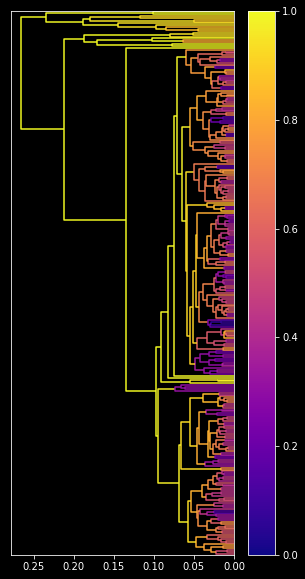

1.8029410197677567
595.9586045742035


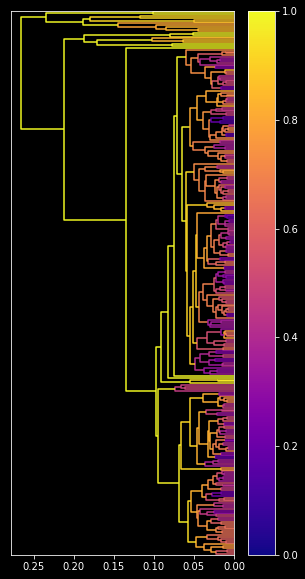

In [13]:
import time
CSC.sample = 0.15
species = CSC.generate_random()
compressed = CSC.generate_compressed(species)
CSC.sample = 0.15
start= time.time()
print(CSC.calculate_metric(compressed))
print(time.time()-start)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)
CSC.sample = 0.75
start= time.time()
print(CSC.calculate_metric(compressed))
print(time.time()-start)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)

1.7533702432986087
131.62169122695923


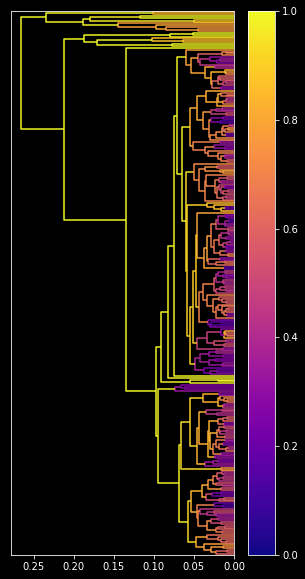

In [14]:
CSC.sample = 0.15
start= time.time()
print(CSC.calculate_metric(compressed))
print(time.time()-start)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)

1.8561883621703335
109.22238373756409


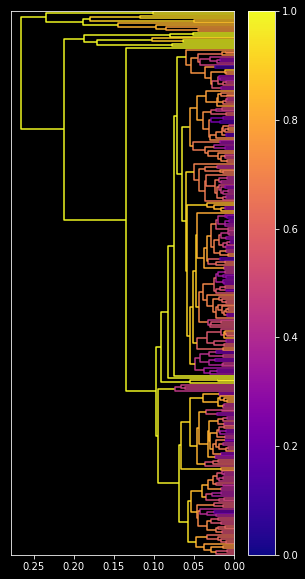

In [15]:
CSC.sample = 0.15
start= time.time()
print(CSC.calculate_metric(compressed))
print(time.time()-start)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)

In [12]:
import matplotlib as mpl
plt.style.use(['dark_background'])
def plot_dendrogram(linkage,accuracy_matrix):
    Z = linkage.copy()
    Z[:,2] = np.log10(Z[:,2]+1)
    cmap = matplotlib.cm.plasma(accuracy_matrix)
    temp = [matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap]
    link_cols = {}
    for i,c in enumerate(temp):
        link_cols[i] = c
    ax = plt.figure(figsize=[5,10])
    D = shc.dendrogram(Z=Z,
                       link_color_func=lambda x: link_cols[x],
                       orientation='left',no_labels=True)
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(norm=norm,cmap='plasma')
    sm.set_array([])
    plt.colorbar(sm)
    plt.show()

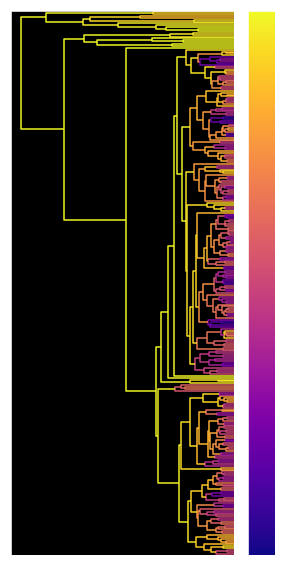

In [52]:
species = CSC.generate_random()
compressed = CSC.generate_compressed(species)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)

In [ ]:
species = CSC.survivors[0]
compressed = CSC.generate_compressed(species)
accuracy_matrix = CSC.calculate_node_accuracy(compressed)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=node_df.columns)
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)